# PittPACC NUISANCE3 Demo

## Reading event vectors

NUISANCE3 uses 'input handlers' in a similar way to NUISANCE2, but with much stricter de-coupling of the input converter logic from the rest of the framework. An input handler's job is to read some vector and return an event stream in NuHepMC format.

First, lets generate a small NuWro file using shell magic and some NUISANCE2 helper scripts

In [1]:
%%bash
if [ ! -e NuWro.numu.BNB_uBooNE.100k.root ]; then
    mkdir -p nuwrogen
    cd nuwrogen
    nuis gen NuWro -E MicroBooNE -n 100000 -t Ar -P numu -o NuWro.numu.BNB_uBooNE.100k.root &> /dev/null
    cp NuWro.numu.BNB_uBooNE.100k.root ../
    cd ../
    rm -r nuwrogen
fi

Success!

Lets first import a few useful modules that we will use in this demo

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyNUISANCE as pn

Welcome to JupyROOT 6.30/04


Next we get an `eventinput` handle to the event stream of the file that we just created with the `pyNUISANCE.EventSource` factory function. Unlike NUISANCE2 we don't have to specify the file type, the EventSource factory can work it out in most cases.

In [3]:
nuevs = pn.EventSource("NuWro.numu.BNB_uBooNE.100k.root")
if not nuevs:
    print("failed to read NuWro.numu.BNB_uBooNE.100k.root")

We can loop over the events in the file sequentially in python like below:

In [4]:
for i, (ev, cvw) in enumerate(nuevs):
    print(ev,cvw)
    if i >= 5:
        break

<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff4d247730> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff4d24cd30> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff700184f0> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff4d247730> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff4d271c70> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff4d275e30> 1.0


Here we can see that the objects returned from iterating on the event source are HepMC3 events. You may also notice the `cvw` variable that comes with every event, this is the Central Value Weight. Different generators store different information in this weight, for many generators it will be `1.0` for every event. However, you shouldn't neglect this weight in generator-agnostic code.

We can use the `pyHepMC3` print functions to print out an event listing and take a look:

In [5]:
import pyHepMC3.pyHepMC3.HepMC3 as hm3

hm3.Print.content(nuevs.first()[0])

--------------------------------
--------- EVENT CONTENT --------
--------------------------------

Weights (1): 
 1Attributes:
0: LabPos
2: remnant_particle_number
0: signal_process_id
GenParticlePtr (11)
GenParticle:   1 PDGID: 1000180400 (P,E)=+0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00 Stat: 20 PV: 0 EV: -1 Attr: 0
GenParticle:   2 PDGID: 2009900000 (P,E)=+0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00 Stat: 3 PV: -1 EV: -3 Attr: 1 remnant_particle_number=1000170390
GenParticle:   3 PDGID:  2212 (P,E)=+1.70e+01,+4.43e+00,+1.04e+02,+9.44e+02 Stat: 21 PV: -1 EV: -2 Attr: 0
GenParticle:   4 PDGID:    14 (P,E)=+0.00e+00,+0.00e+00,+6.90e+02,+6.90e+02 Stat: 4 PV: 0 EV: -2 Attr: 0
GenParticle:   5 PDGID:    13 (P,E)=-4.59e+01,+1.04e+02,+1.46e+02,+2.13e+02 Stat: 3 PV: -2 EV: -3 Attr: 0
GenParticle:   6 PDGID:   211 (P,E)=+1.12e+02,+9.88e+01,+2.97e+02,+3.61e+02 Stat: 3 PV: -2 EV: -3 Attr: 0
GenParticle:   7 PDGID:  2212 (P,E)=-4.91e+01,-1.98e+02,+3.51e+02,+1.02e+03 Stat: 3 PV: -2 EV: -3 Attr: 0
GenPart

So now we can read event vectors from disk and get events from them in a common format. This is some progress.

Note that every time you iterate on the `eventinput` instance, the file will be read from the start again.

Before moving on, it is worth highlighting how you can access the 'run-level' metadata from an event vector. When using native HepMC3 input, the 'GenRunInfo' object is read from the file, but when using a nuisance3 `eventinput` plugin to convert between a generator-specific format and HepMC3 on the fly, that GenRunInfo will contain whatever relevant information the plugin author can glean from the generator-specific file or knows already about the relevant generator format.

The NuWro converter plugin uses the code [here](https://github.com/NuHepMC/nuwro2hepmc3) for the conversion.

We can use `pyHepMC3` print to look at the GenRunInfo.

For more information on the NuHepMC run-level metadata specification, see [here](https://arxiv.org/pdf/2310.13211).

In [6]:
hm3.Print.listing(nuevs.run_info())

________________________________________________________________________
GenRunInfo:
 Names: ( CV )
 Tools: 
GenRunInfo::ToolInfo NuWro UNKNOWN-VERSION https://doi.org/10.1016/j.nuclphysbps.2012.09.136GenRunInfo::ToolInfo nuwro2hepmc3 0.9 github.com/NuHepMC/nuwro2hepmc3Attributes:
NuHepMC.Conventions G.C.1 G.C.2 G.C.5 G.C.4 E.C.1
NuHepMC.Exposure.NEvents 100000
NuHepMC.FluxAveragedTotalCrossSection 0.00942725837682904
NuHepMC.ParticleStatusIDs 1 2 3 4 20 21
NuHepMC.ParticleStatusInfo[1].Description Physical final state particles produced by this simulation
NuHepMC.ParticleStatusInfo[1].Name UndecayedPhysicalParticle
NuHepMC.ParticleStatusInfo[20].Description The target particle in the hard scatter
NuHepMC.ParticleStatusInfo[20].Name TargetParticle
NuHepMC.ParticleStatusInfo[21].Description The nucleon involved in the hard scatter
NuHepMC.ParticleStatusInfo[21].Name StruckNucleon
NuHepMC.ParticleStatusInfo[2].Description Particle was decayed by the simulation
NuHepMC.ParticleStatusInfo[

## Event Analysis

So, you're now free to write your analysis with whatever tools you want! The native `pyHepMC3` bindings are pretty clunky, [Scikit-HEP](https://scikit-hep.org) includes some much more ergonomic bindings under the `pyhepmc` package. The only problem is that the python types are not compatible with the native bindings and so to use `pyhepmc` you need to read the file off disk with `pyhepmc.open` and not using the NUISANCE3 `eventinput` framework. We can use `eventinput` to do the initial conversion, write the converted file to disk and then do follow-up analysis with `pyhepmc`.

Scikit-HEP has a bunch of really really useful tools, and I recommend taking a look at them and including them in your workflows.

In [7]:
wrtr = hm3.WriterAscii("NuWro.numu.BNB_uBooNE.100k.hepmc3")
for ev, _ in nuevs:
    wrtr.write_event(ev)
wrtr.close()

In [6]:
%%bash
head -50 NuWro.numu.BNB_uBooNE.100k.hepmc3

HepMC::Version 3.03.00
HepMC::Asciiv3-START_EVENT_LISTING
W CV
T NuWro\|UNKNOWN-VERSION\|https://doi.org/10.1016/j.nuclphysbps.2012.09.136
T nuwro2hepmc3\|0.9\|github.com/NuHepMC/nuwro2hepmc3
A NuHepMC.Conventions G.C.1 G.C.2 G.C.5 G.C.4 E.C.1
A NuHepMC.Exposure.NEvents 100000
A NuHepMC.FluxAveragedTotalCrossSection 0.00942725837682904
A NuHepMC.ParticleStatusIDs 1 2 3 4 20 21
A NuHepMC.ParticleStatusInfo[1].Description Physical final state particles produced by this simulation
A NuHepMC.ParticleStatusInfo[1].Name UndecayedPhysicalParticle
A NuHepMC.ParticleStatusInfo[20].Description The target particle in the hard scatter
A NuHepMC.ParticleStatusInfo[20].Name TargetParticle
A NuHepMC.ParticleStatusInfo[21].Description The nucleon involved in the hard scatter
A NuHepMC.ParticleStatusInfo[21].Name StruckNucleon
A NuHepMC.ParticleStatusInfo[2].Description Particle was decayed by the simulation
A NuHepMC.ParticleStatusInfo[2].Name DecayedPhysical
A NuHepMC.ParticleStatusInfo[3].Descriptio

In [8]:
import pyhepmc

with pyhepmc.open("NuWro.numu.BNB_uBooNE.100k.hepmc3") as rdr:
    ev = rdr.read()
print(ev)

________________________________________________________________________
GenEvent: #0
 Momentum units: MEV Position units: CM
 Entries in this event: 3 vertices, 11 particles, 1 weights.
 Position offset: 0, 0, 0, 0
                                    GenParticle Legend
         ID    PDG ID   ( px,       py,       pz,     E )   Stat ProdVtx
________________________________________________________________________
Vtx:     -1 stat:  21 (X,cT): 0
 I:       11000180400 +0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00  20     0
 O:       22009900000 +0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00   3    -1
          3     2212 +1.70e+01,+4.43e+00,+1.04e+02,+9.44e+02  21    -1
Vtx:     -2 stat:   1 (X,cT): 0
 I:       3     2212 +1.70e+01,+4.43e+00,+1.04e+02,+9.44e+02  21    -1
          4       14 +0.00e+00,+0.00e+00,+6.90e+02,+6.90e+02   4     0
 O:       5       13 -4.59e+01,+1.04e+02,+1.46e+02,+2.13e+02   3    -2
          6      211 +1.12e+02,+9.88e+01,+2.97e+02,+3.61e+02   3    -2
          7     2212

In [9]:
ev

<GenEvent momentum_unit=0, length_unit=1, event_number=0, particles=11, vertices=3, run_info=GenRunInfo(tools=[ToolInfo(name='NuWro', version='UNKNOWN-VERSION', description='https://doi.org/10.1016/j.nuclphysbps.2012.09.136'), ToolInfo(name='nuwro2hepmc3', version='0.9', description='github.com/NuHepMC/nuwro2hepmc3')], weight_names=['CV'], attributes={NuHepMC.Conventions: G.C.1 G.C.2 G.C.5 G.C.4 E.C.1, NuHepMC.Exposure.NEvents: 100000, NuHepMC.FluxAveragedTotalCrossSection: 0.00942725837682904, NuHepMC.ParticleStatusIDs: 1 2 3 4 20 21, NuHepMC.ParticleStatusInfo[1].Description: Physical final state particles produced by this simulation, NuHepMC.ParticleStatusInfo[1].Name: UndecayedPhysicalParticle, NuHepMC.ParticleStatusInfo[20].Description: The target particle in the hard scatter, NuHepMC.ParticleStatusInfo[20].Name: TargetParticle, NuHepMC.ParticleStatusInfo[21].Description: The nucleon involved in the hard scatter, NuHepMC.ParticleStatusInfo[21].Name: StruckNucleon, NuHepMC.ParticleStatusInfo[2].Description: Particle was decayed by the simulation, NuHepMC.ParticleStatusInfo[2].Name: DecayedPhysical, NuHepMC.ParticleStatusInfo[3].Description: Documentation line, not considered a real particle, NuHepMC.ParticleStatusInfo[3].Name: DocumentationLine, NuHepMC.ParticleStatusInfo[4].Description: Incoming beam particle, NuHepMC.ParticleStatusInfo[4].Name: IncomingBeamParticle, NuHepMC.ProcessIDs: 100 150 200 201 250 251 300 350 400 450 500 550 600 650 700 750, NuHepMC.ProcessInfo[100].Description: coherent, NuHepMC.ProcessInfo[100].Name: CC coh, NuHepMC.ProcessInfo[150].Description: coherent, NuHepMC.ProcessInfo[150].Name: NC coh, NuHepMC.ProcessInfo[200].Description: (quasi) elastic, NuHepMC.ProcessInfo[200].Name: CC qel, NuHepMC.ProcessInfo[201].Description: hyperon production, NuHepMC.ProcessInfo[201].Name: CC hyp, NuHepMC.ProcessInfo[250].Description: (quasi) elastic, NuHepMC.ProcessInfo[250].Name: NC qel, NuHepMC.ProcessInfo[251].Description: hyperon production, NuHepMC.ProcessInfo[251].Name: NC hyp, NuHepMC.ProcessInfo[300].Description: meson exhange current, NuHepMC.ProcessInfo[300].Name: CC mec, NuHepMC.ProcessInfo[350].Description: meson exhange current, NuHepMC.ProcessInfo[350].Name: NC mec, NuHepMC.ProcessInfo[400].Description: delta resonant, NuHepMC.ProcessInfo[400].Name: CC res, NuHepMC.ProcessInfo[450].Description: delta resonant, NuHepMC.ProcessInfo[450].Name: NC res, NuHepMC.ProcessInfo[500].Description: non-delta single pion, NuHepMC.ProcessInfo[500].Name: CC non-delta SPP, NuHepMC.ProcessInfo[550].Description: non-delta single pion, NuHepMC.ProcessInfo[550].Name: NC non-delta SPP, NuHepMC.ProcessInfo[600].Description: deep inelastic, NuHepMC.ProcessInfo[600].Name: CC dis, NuHepMC.ProcessInfo[650].Description: deep inelastic, NuHepMC.ProcessInfo[650].Name: NC dis, NuHepMC.ProcessInfo[700].Description: neutrino-lepton, NuHepMC.ProcessInfo[700].Name: CC lep, NuHepMC.ProcessInfo[750].Description: neutrino-lepton, NuHepMC.ProcessInfo[750].Name: NC lep, NuHepMC.Provenance.NuWro.MEC_cm_direction:  0, NuHepMC.Provenance.NuWro.MEC_pauli_blocking:  1, NuHepMC.Provenance.NuWro.beam_atmo_files: , NuHepMC.Provenance.NuWro.beam_content: , NuHepMC.Provenance.NuWro.beam_direction:  0 0 1, NuHepMC.Provenance.NuWro.beam_energy:  1000, NuHepMC.Provenance.NuWro.beam_file_first:  1, NuHepMC.Provenance.NuWro.beam_file_limit:  0, NuHepMC.Provenance.NuWro.beam_folder:  flux, NuHepMC.Provenance.NuWro.beam_inputroot:  /opt/nuisance/git_master/data/flux/bin_content_is_rate/BNB_uBooNE_numu_flux_2019.root, NuHepMC.Provenance.NuWro.beam_inputroot_flux:  numu, NuHepMC.Provenance.NuWro.beam_inputroot_nue:  , NuHepMC.Provenance.NuWro.beam_inputroot_nueb:  , NuHepMC.Provenance.NuWro.beam_inputroot_numu:  , NuHepMC.Provenance.NuWro.beam_inputroot_numub:  , NuHepMC.Provenance.NuWro.beam_inputroot_nutau:  , NuHepMC.Provenance.NuWro.beam_inputroot_nutaub:  , NuHepMC.Provenance.NuWro.beam_length_units:  cm, NuHepMC.Provenance.NuWro.beam_offset:  0 0 0

For this tutorial, I will mainly use `pyProSelecta` tooling, but now that you can loop on events and get them in a common format, you are welcome to write analyses however you want. The main aim of NUISANCE3 is interoperability.

ProSelecta is a framework for writing declarative event selection and projection operators in C++. It provides a minimal set of 'helper' functions to achieve this, they are broken down into three categories:

* event: Search events for particles by pdg MC codes
* part: Operates on particles or lists thereof
* vect: Some additional 3-vector functions supplementing HepMC3::FourVector

More details [here](https://github.com/NUISANCEMC/ProSelecta/blob/main/README.md).

I'm not going to step through this step-by-step, I'm just going to give an example of how we can convert an event stream into selected and projected tabular data (think 'flat tree') for onward analysis. First a simple example in 'pure' python, and then a more involved example leveraging cling to JIT some C++ for us.

In [4]:
import pyProSelecta as pps

def sel_cc0pi(ev):
    if not pps.event.has_beam_part(ev,14):
        return False
    beam_numu = pps.event.beam_part(ev,14)
    
    num_out_part = pps.event.num_out_part(ev)
    num_out_nucleons = pps.event.num_out_part(ev, 2212) + pps.event.num_out_part(ev, 2112)
    num_out_muon = pps.event.num_out_part(ev, 13)

    return num_out_part == (num_out_nucleons + num_out_muon)
        

def enu_plep_gev(ev):
    vals = [pps.kMissingDatum, pps.kMissingDatum]

    if pps.event.has_beam_part(ev,14):
        vals[0] = pps.event.beam_part(ev,14).momentum().e() / pps.unit.GeV

    if pps.event.has_out_part(ev,13):
        vals[1] = pps.event.hm_out_part(ev,13).momentum().e() / pps.unit.GeV

    return vals

ProSelecta has a very 'look before you leap' philosophy. The API aims to never return a nullptr and so if you try and fetch a particle without safetly checking that the particle exists, it will throw an exception.

Additionally, projection functions that return multiple projections should always return the same number of projections, with invalid entries set to `pps.kMissingDatum`. This enables clean columnar data with clearly-flagged unfilled entries.

Lets test these functions on a few events.

**N.B.** ProSelecta works with the `pyHepMC3` bindings and not the `pyhepmc` bindings, we will use the `eventinput` that we set up earlier.

In [7]:
for i, (ev, cvw) in enumerate(nuevs):
    sel = sel_cc0pi(ev)
    vals = enu_plep_gev(ev)
    if vals[1] != pps.kMissingDatum:
        print(f"event {i} with weight {cvw}, is CC0Pi? {sel}, with enu = {vals[0]:.2f} GeV, and plep = {vals[1]:.2f} GeV")
    else:
        print(f"event {i} with weight {cvw}, is CC0Pi? {sel}, with enu = {vals[0]:.2f} GeV")
    if i >= 5:
        break

event 0 with weight 1.0, is CC0Pi? False, with enu = 0.69 GeV, and plep = 0.21 GeV
event 1 with weight 1.0, is CC0Pi? False, with enu = 0.40 GeV
event 2 with weight 1.0, is CC0Pi? False, with enu = 1.07 GeV, and plep = 0.25 GeV
event 3 with weight 1.0, is CC0Pi? False, with enu = 1.25 GeV, and plep = 0.57 GeV
event 4 with weight 1.0, is CC0Pi? True, with enu = 0.38 GeV, and plep = 0.20 GeV
event 5 with weight 1.0, is CC0Pi? True, with enu = 0.45 GeV, and plep = 0.39 GeV


Now to produce a table of all selected events from the input file.

In [12]:
ev_frame = pn.EventFrameGen(nuevs).filter(sel_cc0pi).add_columns(["enu","plep"], enu_plep_gev).all()

In [13]:
print(ev_frame)
print(f"Number of selected events: {ev_frame.num_rows}")

 -----------------------------------------------------------
 | event.number | weight.cv | process.id |    enu |   plep |
 -----------------------------------------------------------
 |            4 |         1 |        200 | 0.3762 | 0.2013 |
 |            5 |         1 |        200 | 0.4516 | 0.3879 |
 |            8 |         1 |        200 | 0.5129 |   0.42 |
 |            9 |         1 |        300 | 0.7989 | 0.1664 |
 |           11 |         1 |        200 |  1.524 |  1.053 |
 |           13 |         1 |        400 |  1.738 |  1.276 |
 |           14 |         1 |        200 |  1.256 |  1.108 |
 |           15 |         1 |        400 |  1.163 | 0.3685 |
 |           19 |         1 |        300 | 0.5391 | 0.4561 |
 |           21 |         1 |        300 |  0.784 | 0.3599 |
 |           22 |         1 |        500 |  1.007 | 0.1851 |
 |           23 |         1 |        200 |  1.084 | 0.8987 |
 |           25 |         1 |        200 |  1.113 | 0.9846 |
 |           27 |       

These `EventFrame`s are great for working entirely in memory with only homogenous double-type columns. For saving to disk for later processing, or for interacting with other dataframe libraries, we provide a fully featured Apache Arrow interface that allows for typed columns, saving to disk in a variety of formats, and interop with a rich ecosystem of 'data science' tools.

In [8]:
ev_frame_arrow = pn.EventFrameGen(nuevs).filter(sel_cc0pi).add_double_columns(["enu","plep"], enu_plep_gev).firstArrow(100000)
print(ev_frame_arrow)

pyarrow.RecordBatch
event.number: int64
weight.cv: double
process.id: int64
fatx.estimate: double
enu: double
plep: double


`pyarrow` has first class support for conversion to a `pandas` dataframe, and `pandas` v2 and later uses Arrow as the backing storage for it's dataframe implementation, so the below conversion is 'free'.

In [24]:
df = ev_frame_arrow.to_pandas()
df

,event.number,weight.cv,process.id,fatx.estimate,enu,plep
0,4,1.0,200,0.37709,0.376179,0.201309
1,5,1.0,200,0.37709,0.451588,0.387897
2,8,1.0,200,0.37709,0.512935,0.420039
3,9,1.0,300,0.37709,0.798897,0.166363
4,11,1.0,200,0.37709,1.524072,1.052957
...,...,...,...,...,...,...
53508,99992,1.0,200,0.37709,1.378313,1.258990
53509,99993,1.0,200,0.37709,0.807081,0.653338
53510,99994,1.0,200,0.37709,1.165197,0.966825
53511,99996,1.0,300,0.37709,0.986174,0.541077


In [31]:
df_slice = df[(df["enu"] > 0.9) & (df["enu"] < 1.1)]
df_slice["plep"]

10       0.185094
11       0.898678
15       0.585521
19       0.346800
21       0.473770
           ...   
53490    0.902092
53493    0.652208
53495    0.531312
53498    0.377853
53511    0.541077
Name: plep, Length: 9881, dtype: float64

 We can also use pandas to save the dataframe to disk and reload it for later use. The Apache parquet format offers a good compromise of speed and compression, the arrow-native feather format can also be used, which enables memory-mapped IO.

In [1]:
import pandas as pd
import pyarrow as pa

df_slice.to_parquet("NuWro.numu.BNB_uBooNE.CC0Pi.Flat.pq.sn")
df2 = pd.read_parquet("NuWro.numu.BNB_uBooNE.CC0Pi.Flat.pq.sn")
loaded_ev_frame_arrow = pa.Table.from_pandas(df2)

As Apache Arrow has become the *de facto* interop format for data science tools, we can use other data science libraries as well, like polars!

In [5]:
import polars as pl
pl.from_arrow(loaded_ev_frame_arrow)

event.number,weight.cv,process.id,fatx.estimate,enu,plep,__index_level_0__
i64,f64,i64,f64,f64,f64,i64
22,1.0,500,0.37709,1.006763,0.185094,10
23,1.0,200,0.37709,1.083625,0.898678,11
34,1.0,200,0.37709,0.912881,0.585521,15
39,1.0,300,0.37709,0.90976,0.3468,19
41,1.0,200,0.37709,0.995198,0.47377,21
…,…,…,…,…,…,…
99959,1.0,200,0.37709,1.001494,0.902092,53490
99967,1.0,200,0.37709,0.951765,0.652208,53493
99970,1.0,200,0.37709,1.089699,0.531312,53495


## Histograms

For the rest of this demo, we will use the `EventFrame` type for simplicity as we don't need any dataframe functionality or to save things to disk. The `fill_from_EventFrame` function below is one of a family of similar functions for filling histograms from tabular data, when working with arrow Tables, `fill_from_Arrow` should be used instead.

Now we can histogram the event data up and take a look!

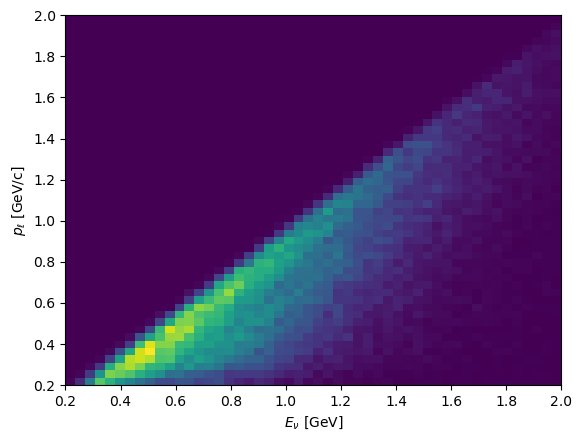

In [14]:
hist = pn.HistFrame(pn.Binning.lin_spaceND([[0.2,2,50],[0.2,2,50]],[r"$E_\nu$ [GeV]",r"$p_\ell$ [GeV/c]"]))
hist.fill_from_EventFrame(ev_frame, ["enu", "plep"])
hist.mpl().hist2d()
plt.show()

We can break up the histogram by interaction mode with a variation of the filling helper, `fill_procid_columns_from_EventFrame` which adds a 'column' to the `HistFrame` for every interaction channel encountered. 

You can think of `HistFrame` columns a bit like 'stacks' in a ROOT histogram. There are no constraints that all columns sum to column zero. Each column represents a set of data assigned to every row in the `HistFrame`, where each row corresponds to a single bin. This structure has many uses, a common use beyond keeping track of sub-samples of a total is to represent systematically varied versions of the histogram, either randomly sampled 'universes' or specific variations used to build histfactory-like response functions (or bin splines in some experimental neutrino analyser parlance).

In [15]:
hist = pn.HistFrame(pn.Binning.lin_spaceND([[0.2,2,50],[0.2,2,50]],[r"$E_\nu$ [GeV]",r"$p_\ell$ [GeV/c]"]))
hist.fill_procid_columns_from_EventFrame(ev_frame, ["enu", "plep"])
print("\n".join([ f"{i}: {x}" for i,x in enumerate(hist.column_info) ] ))

0: Column: name=mc
1: Column: name=200
2: Column: name=300
3: Column: name=400
4: Column: name=500
5: Column: name=600


The interaction process ids are neccessarily generator-specific, but [NuHepMC](https://arxiv.org/pdf/2310.13211#page=11) provides a convention for common blocks of identifiers in E.C.1, *e.g.* 200 is CCQE. It is a requirement of NuHepMC that the process ids are documented in the file itself. We can check back to the GenRunInfo metadata to determine what the different identifers mean.

The `matplotlib` helpers we used on the `HistFrame` before take args to to plot specific columns or to draw to specific axes, by default they plot the first column to the `plt.get_gca()` axis.

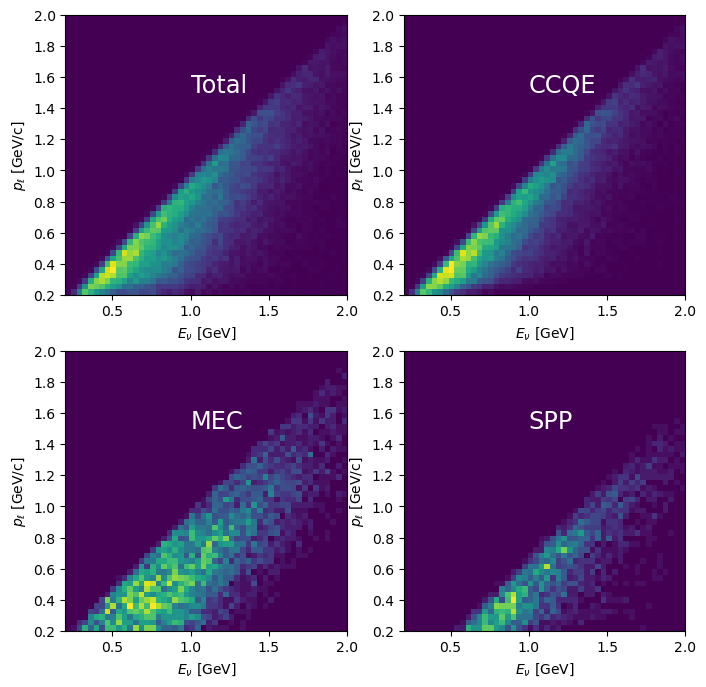

In [16]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))

hist.mpl().hist2d(column="mc", plot_axis=ax1)
ax1.text(1, 1.5, "Total", c="white", fontsize="xx-large")
hist.mpl().hist2d(column="200", plot_axis=ax2)
ax2.text(1, 1.5, "CCQE", c="white", fontsize="xx-large")
hist.mpl().hist2d(column="300", plot_axis=ax3)
ax3.text(1, 1.5, "MEC", c="white", fontsize="xx-large")
hist.mpl().hist2d(column="400", plot_axis=ax4)
ax4.text(1, 1.5, "SPP", c="white", fontsize="xx-large")
fig.show()

The NUISANCE3 Histogramming utility also provide slice and project facilities for working with N-dimensional histograms.

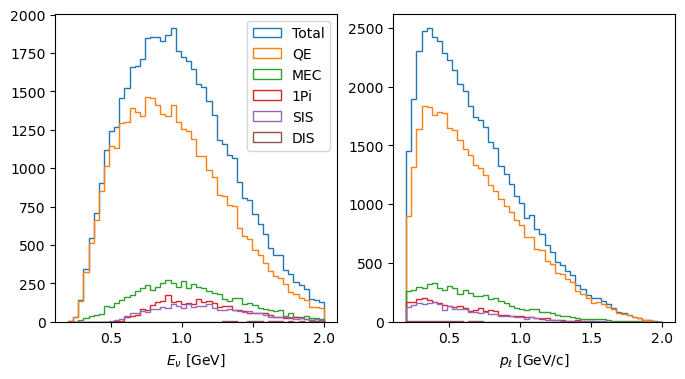

In [19]:
hist_enu = hist.project(0)
hist_pl = hist.project(1)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
hist_enu.mpl().hist_all(plot_axis=ax1, histtype="step", labels=["Total","QE","MEC","1Pi","SIS","DIS"])
hist_pl.mpl().hist_all(plot_axis=ax2, histtype="step")
ax1.legend()
fig.show()

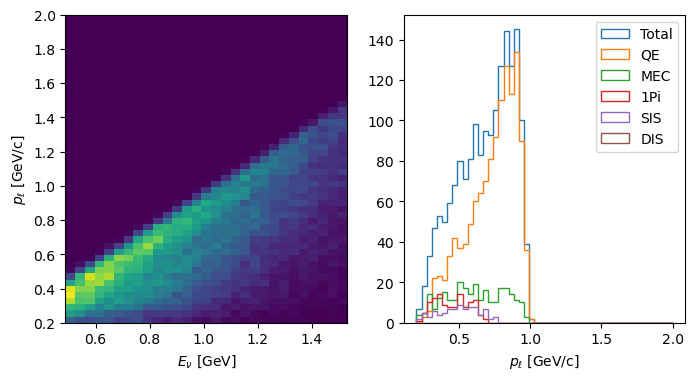

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

hist.slice(0, [0.5,1.5]).mpl().hist2d(plot_axis=ax1)
hist.slice(0, 1).mpl().hist_all(plot_axis=ax2, histtype="step", labels=["Total","QE","MEC","1Pi","SIS","DIS"])
ax2.legend()
plt.show()

## A Data Comparison

NUISANCE3 will interface dynamically to HepData for automated data comparisons. At the time of writing the 350+ samples in NUISANCE2 have not been migrated to HepData, so we provide a NUISANCE2 interface, which lets you use some of the measurements from NUISANCE2 in NUISANCE3.

We have not yet discussed scaling an event rate to a cross section. The ability to do this seemlessly in a generator-agnostic way is a core goal of NuHepMC, as a result it is fairly easy to do in NUISANCE. Both `eventinput` instances and `EventFrames` carefully track the sum of weights squared and the reported flux-averaged total cross section. The scale factor to take a weighted-filled histogram to a cross section prediction is simply to scale by the ratio of the two.

Another detail that I will not dwell on much are that there are two types of binned objects, a `HistFrame` and a `BinnedValues`. A `HistFrame` can be filled and tracks the sum of fill weights and the sum of fill weights squared for each bin. A `BinnedValues` is static and has a value and an error associated with each bin. A `HistFrame` can be `finalise`d to a `BinnedValues` and a `BinnedValues` can spawn an empty `HistFrame` ready for filling.

In [24]:
rf = pn.RecordFactory()
nuis2 = rf.make_record({"type":"nuisance2"})
MicroBooNE_CC1MuNp_XSec_1DPmu_nu = nuis2.table("MicroBooNE_CC1MuNp_XSec_1DPmu_nu")

ev_frame = pn.EventFrameGen(nuevs)\
            .filter(MicroBooNE_CC1MuNp_XSec_1DPmu_nu.select)\
            .add_columns(["Pmu"], MicroBooNE_CC1MuNp_XSec_1DPmu_nu.project)\
            .all()

In [25]:
print(ev_frame)
print(f" The cross section scale factor: {ev_frame.norm_info().fatx_per_sumweights()} pb/A")

 --------------------------------------------------
 | event.number | weight.cv | process.id |    Pmu |
 --------------------------------------------------
 |            4 |         1 |        200 | 0.1714 |
 |            9 |         1 |        300 | 0.1285 |
 |           13 |         1 |        400 |  1.272 |
 |           14 |         1 |        200 |  1.103 |
 |           15 |         1 |        400 |  0.353 |
 |           22 |         1 |        500 |  0.152 |
 |           23 |         1 |        200 | 0.8924 |
 |           25 |         1 |        200 |  0.979 |
 |           27 |         1 |        300 | 0.9544 |
 |           31 |         1 |        500 | 0.4367 |
 |           34 |         1 |        200 | 0.5759 |
 |           35 |         1 |        200 |  1.093 |
 |           37 |         1 |        200 | 0.4253 |
 |           38 |         1 |        200 | 0.6822 |
 |           40 |         1 |        200 |   1.41 |
 |           41 |         1 |        200 | 0.4618 |
 |          

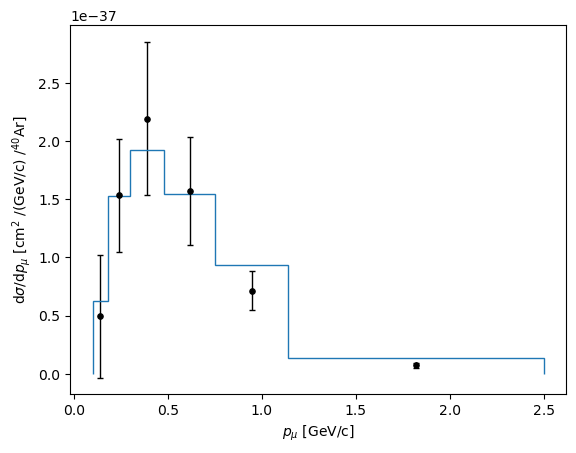

In [26]:
comp = MicroBooNE_CC1MuNp_XSec_1DPmu_nu.comparison()

comp.data.mpl().errorbar(marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)

comp.mc.fill_from_EventFrame(ev_frame,["Pmu"])

pb_to_cm2 = 1E-36
mcpred = comp.mc.finalise().scale(ev_frame.norm_info().fatx_per_sumweights() * pb_to_cm2)

mcpred.mpl().hist(histtype="step")
plt.ylabel(r"d$\sigma$/d$p_{\mu}$ [cm$^{2}$ /(GeV/c) /$^{40}$Ar]")
plt.xlabel(r"$p_{\mu}$ [GeV/c]")
plt.show()

## A HepData Comparison

In [ ]:
%%bash
export NUISANCE_RECORD_DATABASE=$(pwd)
nuis hepdata get-local-path hepdata-sandbox:1713917002/analysis.cxx

In [ ]:
%cat hepdata-sandbox/1713917002/HEPData-1713917002-v1/analysis.cxx